In [2]:
import numpy as np
import math
import matplotlib.pylab as plt
from scipy.stats import norm
import pandas as pd
import json as js
import datetime as dt


In [3]:
def randgen(pr, N=1): 
    L = len(pr)
    return int(np.random.choice(range(L), size=N, replace=True, p=pr))

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    idx = np.where(l_star == float('-inf'))
    l_star[idx] = -1e32
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P

def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def normpdf(x, mean, sd):
        var = float(sd)**2
        pi = 3.1415926
        denom = (2*pi*var)**.5
        num = math.exp(-(float(x)-float(mean))**2/(2*var))
        return num/denom

In [4]:


class HMM(object):
    def __init__(self, pi, A, B_avg, B_sd):
        # p(x_0)
        self.pi = pi
        # p(x_k|x_{k-1})
        self.A = A
        # p(y_k|x_{k})
        self.B_avg = B_avg
        self.B_sd = B_sd
        
        
        # Number of possible latent states at each time
        self.S = pi.shape[0]
        
        self.logB_avg = np.log(self.B_avg)
        self.logB_sd = np.log(self.B_sd)

        self.logA = np.log(self.A)
        self.logpi = np.log(self.pi)
    
    def set_param(self, pi=None, A=None, B=None):
        if pi is not None:
            self.pi = pi
            self.logpi = np.log(self.pi)

        if A is not None:
            self.A = A
            self.logA = np.log(self.A)

        if B_avg is not None:
            self.B_avg = B_avg
            self.logB_avg = np.log(self.B_avg)
            
        if B_sd is not None:
            self.B_sd = B_sd
            self.logB_sd = np.log(self.B_sd)

    @classmethod
    def from_random_parameters(cls, S=3):
        A = np.random.dirichlet(0.7*np.ones(S),S).T
        B_avg = (3*np.random.rand(1,S)).reshape(S)
        B_sd = (np.random.rand(1,S)).reshape(S)
        pi = np.random.dirichlet(0.7*np.ones(S)).T
        return cls(pi, A, B_avg, B_sd)
        
    def __str__(self):
        s = "Prior:\n" + str(self.pi) + "\nA:\n" + str(self.A) + "\nB_avd:\n" + str(self.B_avg)+ "\nB_sd:\n" + str(self.B_sd)
        return s
    
    def __repr__(self):
        s = self.__str__()
        return s
    
    def log_prob_list(self, y):
        l = []
        for i in range(self.S):
            l.append(normpdf(y,self.B_avg[i],self.B_sd[i]))
        return np.log(l)

    def predict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(self.A,np.exp(lp-lstar)))

    def postdict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(np.exp(lp-lstar), self.A))

    def predict_maxm(self, lp):
        return np.max(self.logA + lp, axis=1)

    def postdict_maxm(self, lp):
        return np.max(self.logA.T + lp, axis=1)

    def update(self, y, lp):
        return self.log_prob_list(y) + lp if not np.isnan(y) else lp
    
    
    def generate_sequence(self, T=10):
    # T: Number of steps

        x = np.zeros(T, int)
        y = np.zeros(T, float)

        for t in range(T):
            if t==0:
                x[t] = randgen(self.pi)
            else:
                x[t] = randgen(self.A[:,x[t-1]])  
            
            y[t] =self.B_sd[x[t]] * np.random.randn() + self.B_avg[x[t]]
    
        return y, x

    def forward(self, y, maxm=False):
        T = len(y)
        
        # Forward Pass

        # Python indices start from zero so
        # log \alpha_{k|k} will be in log_alpha[:,k-1]
        # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
        log_alpha  = np.zeros((self.S, T))
        log_alpha_pred = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred[:,0] = self.logpi
            else:
                if maxm:
                    log_alpha_pred[:,k] = self.predict_maxm(log_alpha[:,k-1])
                else:
                    log_alpha_pred[:,k] = self.predict(log_alpha[:,k-1])

                
            log_alpha[:,k] = self.update(y[k], log_alpha_pred[:,k])
            
        return log_alpha, log_alpha_pred
            
    def backward(self, y, maxm=False):
        # Backward Pass
        T = len(y)
        log_beta  = np.zeros((self.S, T))
        log_beta_post = np.zeros((self.S, T))

        for k in range(T-1,-1,-1):
            if k==T-1:
                log_beta_post[:,k] = np.zeros(self.S)
            else:
                if maxm: 
                    log_beta_post[:,k] = self.postdict_maxm(log_beta[:,k+1])                    
                else:
                    log_beta_post[:,k] = self.postdict(log_beta[:,k+1])

            log_beta[:,k] = self.update(y[k], log_beta_post[:,k])

        return log_beta, log_beta_post
        
    def forward_backward_smoother(self, y):
        log_alpha, log_alpha_pred = self.forward(y)
        log_beta, log_beta_post = self.backward(y)
        
        log_gamma = log_alpha + log_beta_post
        return log_gamma

    def viterbi(self, y):
        T = len(y)
        
        # Forward Pass
        log_alpha  = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha[:,k-1])
                
            log_alpha[:,k] = self.update(y[k], log_alpha_pred)

        xs = list()
        w = np.argmax(log_alpha[:,-1])
        xs.insert(0, w)                
        for k in range(T-2,-1,-1):
            w = np.argmax(log_alpha[:,k] + self.logA[w,:])
            xs.insert(0, w)                
            
        return xs
            
    def get_ll(self,y):
        return log_sum_exp(self.forward_backward_smoother(y))[0][0]

    
    def viterbi_maxsum(self, y):
        '''Vanilla implementation of Viterbi decoding via max-sum'''
        '''This algorithm may fail to find the MAP trajectory as it breaks ties arbitrarily'''
        log_alpha, log_alpha_pred = self.forward(y, maxm=True)
        log_beta, log_beta_post = self.backward(y, maxm=True)
        
        log_delta = log_alpha + log_beta_post
        return np.argmax(log_delta, axis=0)

    
    def correction_smoother(self, y):
        # Correction Smoother
        log_alpha, log_alpha_pred = self.forward(y)
        T = len(y)
        
        ll = self.get_ll(y)
    
        # For numerical stability, we calculate everything in the log domain
        log_gamma_corr = np.zeros_like(log_alpha)
        log_gamma_corr[:,T-1] = log_alpha[:,T-1]

        C2 = np.zeros((self.S, self.S))
        C3_m = np.zeros((1, self.S))
        C3_sd = np.zeros((1, self.S))

        for k in range(T-2,-1,-1):
            log_old_pairwise_marginal = log_alpha[:,k].reshape(1,self.S) + self.logA 
            log_old_marginal = self.predict(log_alpha[:,k])
            log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(self.S,1) - log_old_marginal.reshape(self.S,1)
            log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(self.S)
            C2 += normalize_exp(log_new_pairwise_marginal)
            #print('run : '+ str(k))
            #print(log_new_pairwise_marginal)
            
        C1 = normalize_exp(log_gamma_corr[:,0])
        
        
        delta = normalize_exp(self.forward_backward_smoother(y), axis=0)
        C3_m = np.dot(delta,y)/np.sum(delta,axis=1)
        
        y_broadcast = np.zeros((T, hmm.S))
        y = y.reshape(T,1)
        y_broadcast += y
        y_sd = np.power(y_broadcast - hmm.B_avg,2)
        C3_sd = np.power(np.sum(delta * y_sd.T, axis=1)/np.sum(delta,axis=1),1/2)

        return log_gamma_corr, C1, C2, C3_m, C3_sd, ll
    

    def train_EM(self, y, EPOCH=10):
        
        LL = np.zeros(EPOCH)
        for e in range(EPOCH):
            log_gamma_corr, C1, C2, C3_avg, C3_sd, ll = self.correction_smoother(y)
            LL[e] = ll
            p = normalize(C1 + 0.1, axis=0).reshape(self.S)
            A = normalize(C2, axis=0)
            B_avg = C3_avg
            B_sd = C3_sd

            self.__init__(p, A, B_avg, B_sd)
            
        return LL
 

In [5]:
STATE_COUNT = 4
hmm = HMM.from_random_parameters(S=STATE_COUNT)

y,x = hmm.generate_sequence(300)
#print(hm)
#print(y)
#print(x)
log_alpha, log_alpha_pred = hmm.forward(y)
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))

print('states of generated stream')
print(x)
print('predictions using the HMM model')
print(x_pred)



x_only_y = []
for elem in y:
    x_only_y.append(hmm.log_prob_list(elem))

x_only_y = (np.argmax(x_only_y,axis=1))

print('accuracy of state predictions using only emission parameters')
print((x==x_only_y).sum()/len(x))

print('accuracy of state predictions using HMM parameters')
print((x==x_pred).sum()/len(x))

hmm.train_EM(y)
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))
print('accuracy of state predictions after the training using the same HMM')
#print(x_pred)
print((x==x_pred).sum()/len(x))
print(hmm.A)


hmm = HMM.from_random_parameters(S=STATE_COUNT)

print('accuracy of state predictions using the random model')
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))
print((x==x_pred).sum()/len(x))

hmm.train_EM(y)
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))
print('accuracy of state predictions using the trained model')
#print(x_pred)
print((x==x_pred).sum()/len(x))
print(hmm.A)




/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


states of generated stream
[1 2 3 1 3 1 2 1 1 3 3 1 1 3 1 2 3 1 3 2 1 2 1 3 1 0 3 3 3 1 1 2 1 2 2 1 3
 1 2 1 3 1 2 3 1 3 3 1 3 1 3 3 1 2 1 3 1 0 0 0 1 2 2 1 1 3 1 3 1 0 3 1 2 1
 2 3 1 2 1 3 2 1 0 0 0 3 2 2 2 1 3 2 1 1 3 1 3 1 1 2 3 1 3 1 3 3 1 3 1 2 1
 3 1 2 3 1 3 3 1 2 1 3 1 1 2 1 3 1 1 2 3 3 1 3 1 2 3 1 3 1 2 1 2 3 1 1 2 1
 3 1 2 1 3 1 1 2 1 3 1 3 1 0 2 1 2 2 3 1 1 1 3 3 1 3 1 3 3 2 3 1 1 2 2 3 2
 1 1 2 1 1 1 3 1 1 2 1 2 1 2 3 3 1 2 1 2 1 3 1 2 2 1 3 2 1 2 1 3 1 3 2 1 3
 3 1 3 2 1 2 1 2 2 1 2 1 3 3 1 1 1 3 1 1 3 1 2 1 2 1 1 2 3 3 1 2 1 3 3 3 3
 1 2 3 3 3 0 3 3 3 1 3 3 1 3 1 3 3 1 2 3 1 3 3 2 1 2 2 3 1 3 1 2 2 1 3 2 1
 1 3 1 2]
predictions using the HMM model
[3 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1 0 1 3 1 1 1 1 1 1 3 1 3
 1 1 1 0 1 1 1 1 1 3 1 3 1 1 3 3 1 1 1 0 0 0 0 3 1 2 1 1 1 1 3 1 0 0 3 1 1
 1 1 1 1 1 3 1 1 0 0 0 3 1 3 1 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 1 1 3 1 3 3 1 1 3 1 1 3 1 1 3 1 1 1 3 1 1 3 1 2 1 3 1 2 1 3 1 1 1
 1 1 1 1 1 1 1 3 1 3 1 3 1 0 3 

In [6]:
hmm = HMM.from_random_parameters()
y,x = hmm.generate_sequence(10)

log_gamma_corr, C1, C2, C3_avg, C3_sd, ll = hmm.correction_smoother(y)

print('A Matrix')
print(hmm.A)
print('Next A')
print(normalize(C2, axis=0))
print()
print(hmm.B_avg)
print(C3_avg)
print(ll)

A Matrix
[[0.25068859 0.13239537 0.79776762]
 [0.46485194 0.1121735  0.17372109]
 [0.28445947 0.75543113 0.02851129]]
Next A
[[0.09101917 0.00959018 0.68520716]
 [0.77988849 0.0249252  0.29896259]
 [0.12909234 0.96548462 0.01583026]]

[1.14866456 2.22265288 2.27283375]
[0.78003757 2.52034435 2.27779658]
-10.08812839893194


/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


original A
[[0.04994272 0.00330775 0.01476125 0.11279035 0.13527381 0.00352991
  0.01195555 0.28474921]
 [0.48230243 0.20015207 0.11098424 0.33907692 0.16638825 0.03912203
  0.01930254 0.27217327]
 [0.01462947 0.03164034 0.18224758 0.1315031  0.13917767 0.00064066
  0.02730968 0.00314088]
 [0.00365346 0.00189341 0.30707881 0.01063751 0.02760255 0.01062425
  0.08228535 0.06768435]
 [0.09068665 0.03240293 0.01172918 0.05822387 0.24233524 0.17268258
  0.09941892 0.18314912]
 [0.29397978 0.09049057 0.06459119 0.26516616 0.00560968 0.0071592
  0.39128746 0.00776633]
 [0.02064784 0.03217072 0.00214508 0.0036199  0.04980359 0.50317002
  0.31403273 0.04434051]
 [0.04415765 0.60794221 0.30646268 0.07898218 0.23380921 0.26307136
  0.05440776 0.13699633]]
original B_avg
[1.9639668  2.54190721 0.71642684 1.00055949 1.91641586 0.18027844
 2.5966422  1.40118812]
original B_std
[0.73210697 0.33609706 0.94919839 0.3798595  0.07652361 0.03130195
 0.91657108 0.55310409]
original ll for the first series


/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


original ll for the second series for trained hmm
-129.15417001213734
learned A
[[7.96028848e-002 1.70109077e-038 2.83756127e-030 2.26657548e-001
  1.27718118e-008 2.78375919e-029 4.35299399e-001 4.61250870e-036]
 [1.35572807e-021 0.00000000e+000 1.72038782e-149 1.10039183e-120
  0.00000000e+000 6.89191801e-054 1.07689509e-001 2.49382992e-001]
 [3.25149100e-031 2.00116175e-001 0.00000000e+000 1.64552316e-001
  7.64694327e-291 3.78210964e-029 7.09271511e-002 1.72368888e-132]
 [4.75379776e-002 2.92092690e-046 1.43551974e-007 6.85062209e-034
  6.84347457e-001 4.00798430e-048 1.57521771e-016 4.46648897e-162]
 [7.43140089e-103 3.77121717e-236 6.07708228e-001 0.00000000e+000
  0.00000000e+000 6.20478316e-001 1.79580944e-080 2.49700828e-001]
 [9.62139898e-002 4.82364149e-192 7.43104943e-056 2.78718233e-001
  2.09508726e-001 2.08613016e-001 3.65460942e-002 2.96262446e-059]
 [7.76645148e-001 5.62040948e-102 3.92291628e-001 3.30071903e-001
  1.06143805e-001 1.70908668e-001 3.49537847e-001 5.0091

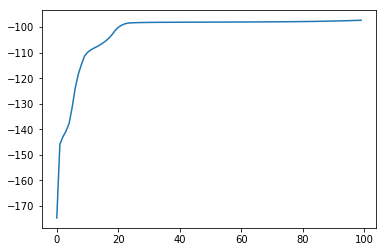

In [7]:
STATE_COUNT = 8

hmm = HMM.from_random_parameters(S=STATE_COUNT)
y,x = hmm.generate_sequence(100)

y2,x2 = hmm.generate_sequence(100)

print('original A')
print(hmm.A)
print('original B_avg')
print(hmm.B_avg)
print('original B_std')
print(hmm.B_sd)

print('original ll for the first series')
print(hmm.get_ll(y))
print('original ll for the second series')
print(hmm.get_ll(y2))


#reinitialize hmm
hmm = HMM.from_random_parameters(S=STATE_COUNT)


print('original ll for the second series for random hmm')
print(hmm.get_ll(y2))

LL = hmm.train_EM(y,EPOCH = 100)


print('original ll for the second series for trained hmm')
print(hmm.get_ll(y2))

print('learned A')
print(hmm.A)
print('learned B_avg')
print(hmm.B_avg)
print('learned B_std')
print(hmm.B_sd)
plt.plot(LL)
plt.show()

In [8]:
l = [float('-Inf'),float('-Inf')]
l_star = np.max(l, keepdims=True)
idx = np.where(l_star == float('-inf'))
l_star[idx] = -1e32
ret = l_star + np.log(np.sum(np.exp(l - l_star),keepdims=True)) 
print(ret)

print(float('-inf')-float('-inf'))

[-inf]
nan


/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
